In [1]:
import torch

/home/zheyu/Anaconda/envs/robosaga/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
n_samples = 10000
buffer_watcher = torch.zeros(n_samples)
global_indices = torch.arange(n_samples)
data = torch.randn(n_samples, 10)

batch_size = 100
update_percent = 0.1

n_epochs = 11
for _ in range(n_epochs):
    global_ids = torch.randperm(n_samples)
    for i in range(0, n_samples, batch_size):
        current_global_ids = global_ids[i:i+batch_size]
        batch_indices = torch.arange(0, batch_size) 
        update_freq = buffer_watcher[current_global_ids]
        sorted_update_freq, sorted_indices = torch.sort(update_freq)
        batch_indices = batch_indices[sorted_indices]
        current_global_ids = current_global_ids[sorted_indices]
        n_update_samples = int(batch_size * update_percent)
        buffer_watcher[current_global_ids[:n_update_samples]] += 1
    updated_sample_count = torch.sum(buffer_watcher > 0)
    print(f"Buffer watcher: {updated_sample_count/n_samples} samples seen")

Buffer watcher: 0.10000000149011612 samples seen
Buffer watcher: 0.20000000298023224 samples seen
Buffer watcher: 0.30000001192092896 samples seen
Buffer watcher: 0.4000000059604645 samples seen
Buffer watcher: 0.5 samples seen
Buffer watcher: 0.6000000238418579 samples seen
Buffer watcher: 0.699999988079071 samples seen
Buffer watcher: 0.800000011920929 samples seen
Buffer watcher: 0.8999999761581421 samples seen
Buffer watcher: 0.9889000058174133 samples seen
Buffer watcher: 1.0 samples seen


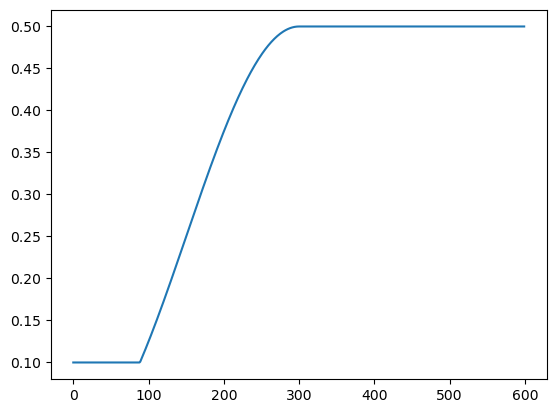

In [9]:
import numpy as np
from math import cos, pi
import matplotlib.pyplot as plt

aug_ratio = 0.5
saturation_epoch = 300
epoch_idx = np.arange(0, 600)  
update_ratio = 0.1

lambda_ = 0.5 * (1 - np.cos(epoch_idx * pi / saturation_epoch))
lambda_[epoch_idx > saturation_epoch] = 1
aug_ratio = aug_ratio * lambda_
aug_ratio[aug_ratio < update_ratio] = update_ratio

plt.plot(epoch_idx, aug_ratio)

In [3]:
import os
from PIL import Image

def crop_and_save_as_png(image_path):
    img = Image.open(image_path)
    is_jpg = image_path.endswith('.jpg')    
    width, height = img.size
    # if width != height or is_jpg:
    min_dim = min(width, height)
    left = (width - min_dim)/2
    top = (height - min_dim)/2
    right = (width + min_dim)/2
    bottom = (height + min_dim)/2
    img = img.crop((left, top, right, bottom))
    img = img.resize((800, 800))
    image_path_new = os.path.splitext(image_path)[0] + '.png'
    img.save(image_path_new, 'PNG')
    # save n randomly cropped and rotated images
    for i in range(1, 4):
        img = img.rotate(90 * i)
        img.save(os.path.splitext(image_path)[0] + f'_{i}.png', 'PNG')
    
    
    if is_jpg:
        os.remove(image_path)

directory = '/home/zheyu/RoboSaGA/robosuite/robosuite/models/assets/textures/evaluation_textures/outdoor'
for filename in os.listdir(directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        crop_and_save_as_png(os.path.join(directory, filename))
        
        

In [29]:
import h5py

def print_hdf5_structure(file_path):
    with h5py.File(file_path, 'r') as file:
        print(f"Structure of HDF5 file: {file_path}")
        print("-----------------------------")
        print_structure(file['data/demo_0'])

def print_structure(item, indent=""):
    if isinstance(item, h5py.File):
        print(f"{indent}(File) {item.name}")
        for key in item.keys():
                print_structure(item[key], indent + "  ")
    elif isinstance(item, h5py.Group):
        print(f"{indent}(Group) {item.name}")
        for key in item.keys():
                print_structure(item[key], indent + "  ")
    elif isinstance(item, h5py.Dataset):
        print(f"{indent}(Dataset) {item.name} {item.shape} {item.dtype}")

# Example usage
file_path = '/home/zheyu/Dataset/mimicgen/square_d0.hdf5'
print_hdf5_structure(file_path)


Structure of HDF5 file: /home/zheyu/Dataset/mimicgen/square_d0.hdf5
-----------------------------
(Group) /data/demo_0
  (Dataset) /data/demo_0/actions (136, 7) float64
  (Dataset) /data/demo_0/dones (136,) int64
  (Group) /data/demo_0/obs
    (Dataset) /data/demo_0/obs/agentview_image (136, 84, 84, 3) uint8
    (Dataset) /data/demo_0/obs/object (136, 14) float64
    (Dataset) /data/demo_0/obs/robot0_eef_pos (136, 3) float64
    (Dataset) /data/demo_0/obs/robot0_eef_quat (136, 4) float64
    (Dataset) /data/demo_0/obs/robot0_eef_vel_ang (136, 3) float64
    (Dataset) /data/demo_0/obs/robot0_eef_vel_lin (136, 3) float64
    (Dataset) /data/demo_0/obs/robot0_eye_in_hand_image (136, 84, 84, 3) uint8
    (Dataset) /data/demo_0/obs/robot0_gripper_qpos (136, 2) float64
    (Dataset) /data/demo_0/obs/robot0_gripper_qvel (136, 2) float64
    (Dataset) /data/demo_0/obs/robot0_joint_pos (136, 7) float64
    (Dataset) /data/demo_0/obs/robot0_joint_pos_cos (136, 7) float64
    (Dataset) /data/demo

In [36]:
import h5py
import numpy as np

def copy_group(source_group, target_group):
    """
    Recursively copies a group from the source HDF5 file to the target HDF5 file,
    including all subgroups, datasets, and attributes of each group.
    """
    # Copy attributes of the group
    for attr_name, attr_value in source_group.attrs.items():
        target_group.attrs[attr_name] = attr_value

    # Iterate through items in the group
    for name, item in source_group.items():
        if isinstance(item, h5py.Dataset):
            # Copy dataset from source to target
            target_dataset = target_group.create_dataset(name, data=item[()])
            # Copy dataset attributes
            for attr_name, attr_value in item.attrs.items():
                target_dataset.attrs[attr_name] = attr_value
        elif isinstance(item, h5py.Group):
            # Recursively copy subgroup
            sub_group = target_group.create_group(name)
            copy_group(item, sub_group)

def sample_and_rename_groups(source_file, target_file, base_path='data', sample_size=200):
    with h5py.File(source_file, 'r') as source:
        if base_path not in source:
            raise ValueError(f"The base path {base_path} does not exist in the source file.")
        
        base_group = source[base_path]
        # List all groups in the base path
        group_list = [name for name in base_group if isinstance(base_group[name], h5py.Group)]
        
        # Randomly sample groups without replacement
        if len(group_list) < sample_size:
            raise ValueError("Not enough groups to sample from.")
        sampled_groups = np.random.choice(group_list, size=sample_size, replace=False)
        
        with h5py.File(target_file, 'w') as target:
            target_base_group = target.create_group(base_path)
            target_base_group.attrs.update(base_group.attrs)  # Copy attributes of the base group
            
            # Copy the sampled groups to the new file with new names
            for index, group_name in enumerate(sampled_groups):
                new_group_name = f"demo_{index}"  # New name based on order
                group_path = f"{base_path}/{group_name}"
                print(f"Copying group {group_path} as {new_group_name} to new file...")
                copy_group(source[group_path], target_base_group.create_group(new_group_name))

# Example usage
source_hdf5_path = '/home/zheyu/Dataset/mimicgen/core/stack_three_d0.hdf5'
new_hdf5_path = '/home/zheyu/Dataset/mimicgen/stack_three_d0_200_demos.hdf5'
sample_and_rename_groups(source_hdf5_path, new_hdf5_path)


Copying group data/demo_750 as demo_0 to new file...
Copying group data/demo_543 as demo_1 to new file...
Copying group data/demo_236 as demo_2 to new file...
Copying group data/demo_301 as demo_3 to new file...
Copying group data/demo_45 as demo_4 to new file...
Copying group data/demo_248 as demo_5 to new file...
Copying group data/demo_917 as demo_6 to new file...
Copying group data/demo_289 as demo_7 to new file...
Copying group data/demo_892 as demo_8 to new file...
Copying group data/demo_919 as demo_9 to new file...
Copying group data/demo_315 as demo_10 to new file...
Copying group data/demo_705 as demo_11 to new file...
Copying group data/demo_365 as demo_12 to new file...
Copying group data/demo_977 as demo_13 to new file...
Copying group data/demo_18 as demo_14 to new file...
Copying group data/demo_168 as demo_15 to new file...
Copying group data/demo_471 as demo_16 to new file...
Copying group data/demo_634 as demo_17 to new file...
Copying group data/demo_478 as demo_18 t